In [6]:
from datetime import datetime
import psycopg2
from faker import Faker
import random
import pandas as pd
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Load environment variables
load_dotenv()

# Initialize Faker
fake = Faker()

In [75]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=os.getenv("DB_DATABASE_NAME"),
    user=os.getenv("DB_USERNAME"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"), 
    port=os.getenv("DB_PORT")
)

cursor = conn.cursor()

In [3]:
# Fetch all user IDs from the Users table
cursor.execute('SELECT user_id FROM "Users";')
users = cursor.fetchall()

In [4]:
# Define player type distribution
player_types = {
    "Achievers": 0.10,
    "Explorers": 0.15,
    "Socializers": 0.15,
    "Competitors": 0.10,
    "Creators": 0.15,
    "Story Seekers": 0.10,
    "Casual Players": 0.05,
    "Strategists": 0.10,
    "Collectors": 0.05,
    "Escapists": 0.05
}

gamer_types = {
    "Day-One": 0.10,
    "Wait-and-See": 0.15,
    "Discount": 0.15,
}

In [5]:
# Convert dictionary to weighted choice format
player_type_choices = list(player_types.keys())
player_type_weights = list(player_types.values())

gamer_type_choices = list(gamer_types.keys())
gamer_type_weights = list(gamer_types.values())

user_data = []
for user in users:
    user_id = user[0]
    player_type = random.choices(player_type_choices, player_type_weights)[0]
    gamer_type = random.choices(gamer_type_choices, gamer_type_weights)[0]
    user_data.append({"user_id": user_id, "player_type": player_type, "gamer_type": gamer_type})

# Convert to DataFrame
df = pd.DataFrame(user_data)

# Save as CSV locally
csv_filename = "user_player_types.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' saved successfully!")


CSV file 'user_player_types.csv' saved successfully!


In [65]:
# Close database connection
cursor.close()
conn.close()


# Generating sales data

In [428]:
import pandas as pd
import random
from datetime import datetime, timedelta

In [91]:
df_users = pd.read_csv("user_player_types.csv")

In [92]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=os.getenv("DB_DATABASE_NAME"),
    user=os.getenv("DB_USERNAME"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"), 
    port=os.getenv("DB_PORT")
)

cursor = conn.cursor()

In [106]:
cursor.execute("""
    SELECT g.game_id,g.release_date,g.price, g.discount, g.rating, g.title, ARRAY_AGG(c.name) AS genres
    FROM "Games" g
    JOIN "GameCategories" gc ON g.game_id = gc.game_id
    JOIN "Categories" c ON gc.category_id = c.category_id
    GROUP BY g.game_id, g.title;
""")

games = cursor.fetchall()

In [107]:
games[0]

('4bde6e96-2352-4c65-a61a-b5d153129f64',
 datetime.date(2024, 5, 5),
 Decimal('20.00'),
 0.0,
 4.5,
 'Shadowstrike Royale',
 ['Action', 'Open-world', 'Survival', 'Multiplayer', 'Battle Royale'])

In [108]:
game_data = {}

for game_id, release_date, price, discount, rating, game_name, genres in games:
    game_data[game_id] = {
        "game_id": game_id,
        "name": game_name,
        "release_date": datetime.strptime(str(release_date), "%Y-%m-%d"),  # Convert to datetime
        "price": float(price),
        "discount": float(discount),
        "genres": set(genres),
        "rating": rating,
        "review": "Overwhelmingly Positive"
    }

In [109]:
game_data

{'4bde6e96-2352-4c65-a61a-b5d153129f64': {'game_id': '4bde6e96-2352-4c65-a61a-b5d153129f64',
  'name': 'Shadowstrike Royale',
  'release_date': datetime.datetime(2024, 5, 5, 0, 0),
  'price': 20.0,
  'discount': 0.0,
  'genres': {'Action',
   'Battle Royale',
   'Multiplayer',
   'Open-world',
   'Survival'},
  'rating': 4.5,
  'review': 'Overwhelmingly Positive'},
 '70c5228e-704d-43e9-b29f-0a3f8174ba72': {'game_id': '70c5228e-704d-43e9-b29f-0a3f8174ba72',
  'name': 'Rocket Science Adventures',
  'release_date': datetime.datetime(2024, 1, 10, 0, 0),
  'price': 12.0,
  'discount': 0.0,
  'genres': {'Adventure', 'RPG', 'Sandbox', 'Simulation', 'Strategy'},
  'rating': 4.0,
  'review': 'Overwhelmingly Positive'}}

In [415]:
game_data['70c5228e-704d-43e9-b29f-0a3f8174ba72']['genres'] = {'Multiplayer', 'RPG', 'Sandbox', 'Simulation', 'Strategy'}

In [19]:
def assign_sales_pattern(genres):
    constant_sales_genres = {"Multiplayer", "Battle Royale", "Puzzle", "Casual", "MOBA", "FPS"}
    declining_sales_genres = {"Strategy", "Simulation", "RPG", "Adventure", "Open-world", "Survival"}

    # Check if the game has any genre in the constant sales category
    if any(genre in constant_sales_genres for genre in genres):
        return "constant"
    else:
        return "declining"

In [20]:
def is_holiday(date):
    holidays = [
        {"start": datetime(2024, 12, 15), "end": datetime(2024, 12, 31)},  # Christmas & New Year
        {"start": datetime(2024, 11, 25), "end": datetime(2024, 11, 29)},  # Black Friday
        {"start": datetime(2024, 7, 4), "end": datetime(2024, 7, 6)},  # Independence Day (US)
    ]
    for holiday in holidays:
        if holiday["start"] <= date <= holiday["end"]:
            return True
    return False

In [21]:
def review_boost_from_rating(review_text):
    review_mapping = {
        "Overwhelmingly Positive": 1.3,  # Big boost
        "Mostly Positive": 1.2,  # Moderate boost
        "Somewhat Positive": 1.1,  # Slight boost
        "Neutral": 1.0,  # No change
        "Mostly Negative": 0.8,  # Moderate reduction
        "Negative": 0.5  # Significant reduction
    }
    
    return review_mapping.get(review_text, 1.0)

In [22]:
def rating_boost_from_rating(rating):
    """
    This function takes a rating out of 5 and returns a multiplier for the sales boost.
    """
    if rating == 5:
        return 1.2  # Major boost
    elif rating == 4:
        return 1.0  # Moderate boost
    elif rating == 3:
        return 0.75  # Slight boost
    elif rating == 2:
        return 0.5  # Minor reduction
    else:
        return 0.2  # Significant reduction

In [23]:
def filter_users_by_day(player_data, start_date, days_elapsed, initial_users=100, daily_growth_range=(150, 250), max_users=90000):
    """
    Selects users based on the gradual rollout plan.
    - Starts with `initial_users` on Day 1.
    - Adds `daily_growth_range` new users each day.
    - Capped at `max_users`.
    """
    total_users_allowed = initial_users + sum(random.randint(*daily_growth_range) for _ in range(days_elapsed))
    total_users_allowed = min(total_users_allowed, max_users)  # Ensure we don't exceed max_users
    return player_data.head(total_users_allowed)

In [118]:
# Generate sales transactions for each user
start_date = datetime(2024, 1, 1)

In [119]:
sales_data = []

In [120]:
import random
from datetime import timedelta

In [121]:
def generate_sales_data_with_reviews_and_ratings(game_id, game_name, release_date, price, genres, player_data, game_review, game_rating, start_date, current_date, discount_period=30):
    
    purchase_behavior_data = {
        "Achievers": 5, "Explorers": 4, "Socializers": 3, "Competitors": 5,
        "Creators": 2, "Story Seekers": 2, "Casual Players": 1,
        "Strategists": 3, "Collectors": 2, "Escapists": 2
    }
    
    review_boost = review_boost_from_rating(game_review)
    rating_boost = rating_boost_from_rating(game_rating)
    
    player_types_to_genres = {
        "Achievers": ["Action", "Adventure", "Strategy", "RPG", "Simulation", "FPS", "Puzzle"],
        "Explorers": ["Adventure", "Open-world", "Survival", "RPG", "Puzzle"],
        "Socializers": ["Multiplayer", "Battle Royale", "Simulation", "Puzzle"],
        "Competitors": ["Action", "Strategy", "Shooting", "Battle Royale", "FPS", "MOBA"],
        "Creators": ["Simulation", "Sandbox", "Open-world", "RPG"],
        "Story Seekers": ["Adventure", "RPG", "Simulation"],
        "Casual Players": ["Puzzle", "Simulation"],
        "Strategists": ["Strategy", "RPG", "MOBA", "Shooting"],
        "Collectors": ["RPG", "Card", "Simulation", "Battle Royale"],
        "Escapists": ["Open-world", "Simulation", "RPG", "Survival"]
    }

    sales_data = []
    users_purchased_game = set()

    for purchase_date in pd.date_range(start=start_date, end=current_date, freq='D'):
        
        if purchase_date < release_date:
            continue

        days_since_release = (purchase_date - release_date).days
        
        # Filter users dynamically based on rollout schedule
        active_users = filter_users_by_day(player_data, start_date, days_since_release)
        print("active_users", len(active_users))
        
        for _, user in active_users.iterrows():
            user_id, player_type, gamer_type = user['user_id'], user['player_type'], user['gamer_type']
            
            if user_id in users_purchased_game:
                continue

            
            base_purchases = purchase_behavior_data.get(player_type, 1)
            user_genres = player_types_to_genres.get(player_type, [])
            genre_match_count = len(set(genres).intersection(user_genres))
            genre_match_boost = 0.5 + (genre_match_count * 0.2)

            launch_boost = 1.5 if days_since_release <= 30 else 1.0
            holiday_boost = 1.5 if is_holiday(purchase_date) else 1.0
            
            sales_pattern = assign_sales_pattern(genres)
            decline_factor = 1.0 if sales_pattern == "constant" else max(0.1, math.exp(-0.005 * days_since_release))

            total_boost = launch_boost * holiday_boost * review_boost * rating_boost * decline_factor * genre_match_boost
            adjusted_purchase_probability = (base_purchases / 30) * total_boost
            
            if gamer_type == "Day-One":
                purchase_chance = random.random() < (adjusted_purchase_probability * 1.5 if days_since_release <= 7 else adjusted_purchase_probability)
            elif gamer_type == "Wait-and-See":
                purchase_chance = random.random() < (adjusted_purchase_probability if 30 <= days_since_release <= 60 else 0)
            elif gamer_type == "Discount":
                purchase_chance = random.random() < (adjusted_purchase_probability * 1.2 if is_holiday(purchase_date) or days_since_release > discount_period else 0)
            
            if purchase_chance:
                sales_data.append({
                    "user_id": user_id,
                    "game_id": game_id,
                    "game_name": game_name,
                    "purchase_date": purchase_date,
                    "price": price,
                    "player_type": player_type,
                    "gamer_type": gamer_type,
                    "review_boost": review_boost,
                    "rating_boost": rating_boost,
                    "launch_boost": launch_boost,
                    "holiday_boost": holiday_boost,
                    "decline_factor": decline_factor,
                    "genre_match_boost": genre_match_boost
                })

    return sales_data

In [122]:
start_date = datetime(2024, 1, 1)
current_date = datetime.today()
all_sales_data = []

for game_id, game_info in game_data.items():

    if game_id == "70c5228e-704d-43e9-b29f-0a3f8174ba72":
        continue
    # Extract game details
    game_name = game_info["name"]
    release_date = game_info["release_date"]
    price = game_info["price"]
    genres = game_info["genres"]
    game_review = game_info["review"]
    game_rating = game_info["rating"]

    current_date = datetime.today()
    days_to_simulate = (current_date - release_date).days

    # Call the function to generate sales data for each game
    sales_data = generate_sales_data_with_reviews_and_ratings(
        game_id=game_id,  # Use the game_id directly from game_data
        game_name=game_name,
        release_date=release_date,
        price=price,
        genres=genres,
        player_data=df_users,  # Assuming df_users contains player information
        game_review=game_review,
        game_rating=game_rating,
        start_date = start_date,
        current_date=current_date  # Simulate sales for one year
    )
    all_sales_data.extend(sales_data)

active_users 100
active_users 269
active_users 531
active_users 710
active_users 966
active_users 1203
active_users 1427
active_users 1385
active_users 1686
active_users 1873
active_users 2128
active_users 2225
active_users 2477
active_users 2490
active_users 2881
active_users 2909
active_users 3384
active_users 3427
active_users 3686
active_users 3973
active_users 4080
active_users 4198
active_users 4406
active_users 4733
active_users 4885
active_users 5121
active_users 5352
active_users 5570
active_users 5617
active_users 6119
active_users 6017
active_users 6185
active_users 6559
active_users 6777
active_users 6690
active_users 6976
active_users 7174
active_users 7686
active_users 7760
active_users 7876
active_users 7987
active_users 8595
active_users 8227
active_users 8445
active_users 8978
active_users 9049
active_users 9396
active_users 9176
active_users 9658
active_users 9793
active_users 10095
active_users 10502
active_users 10400
active_users 10978
active_users 10686
active_use

In [123]:
len(all_sales_data)

115170

In [42]:
len(all_sales_data)

385

In [124]:
df_sales = pd.DataFrame(all_sales_data)

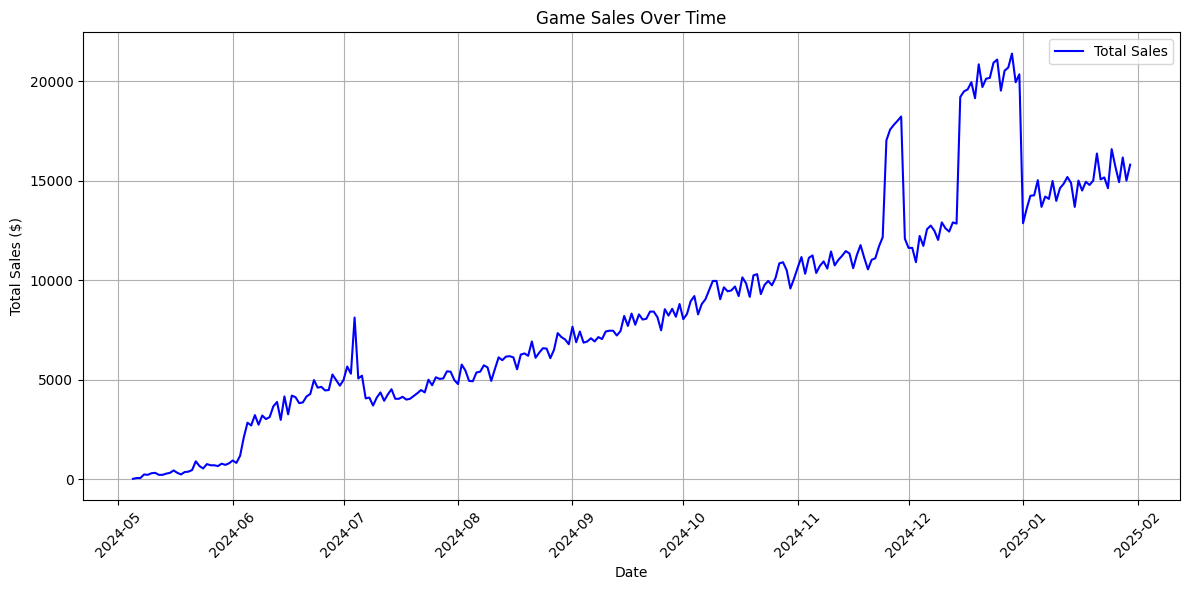

In [125]:
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'])

# Group sales by date and sum the total sales
sales_per_day = df_sales.groupby('purchase_date')['price'].sum()

# Plot the sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_per_day.index, sales_per_day.values, label='Total Sales', color='blue')
plt.title('Game Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

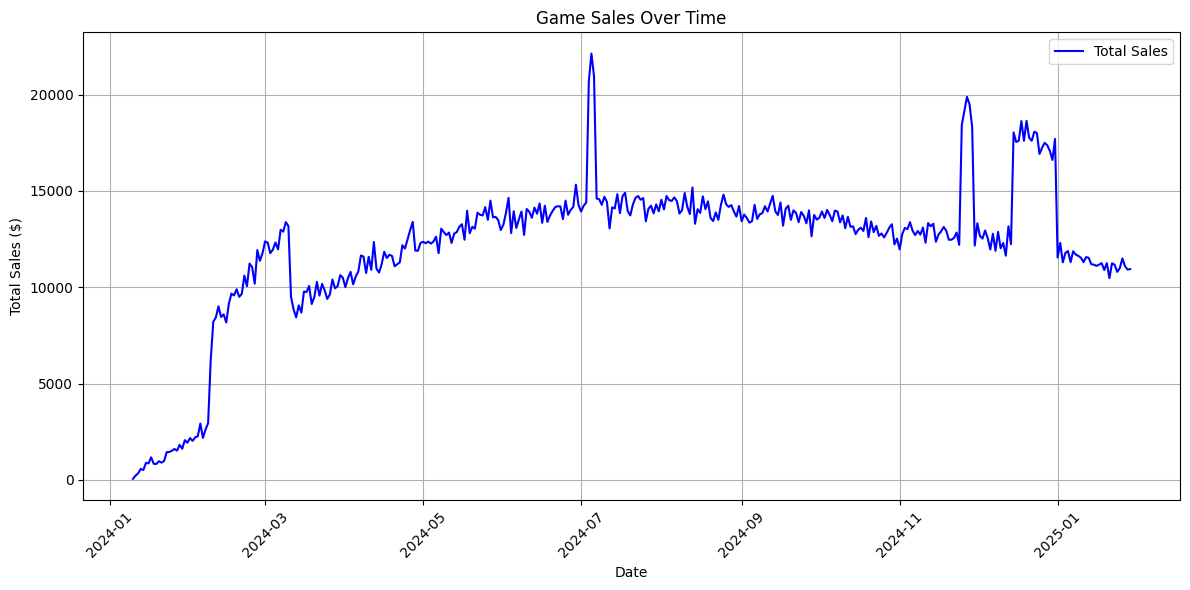

In [60]:
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'])

# Group sales by date and sum the total sales
sales_per_day = df_sales.groupby('purchase_date')['price'].sum()

# Plot the sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_per_day.index, sales_per_day.values, label='Total Sales', color='blue')
plt.title('Game Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

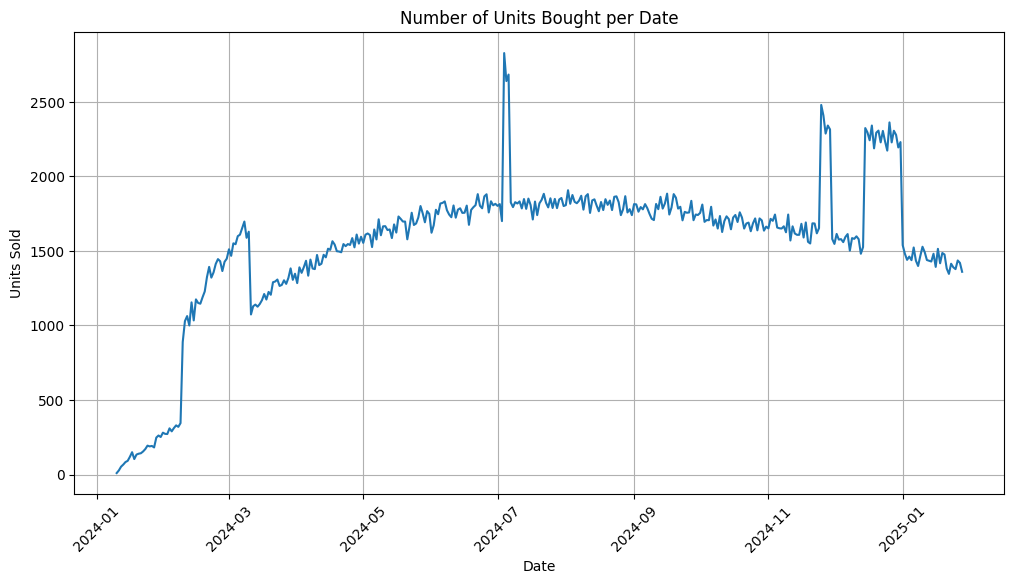

In [54]:
sales_per_day = df_sales.groupby("purchase_date").size()

# Plot the sales trend
plt.figure(figsize=(12, 6))
plt.plot(sales_per_day.index, sales_per_day.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Number of Units Bought per Date")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

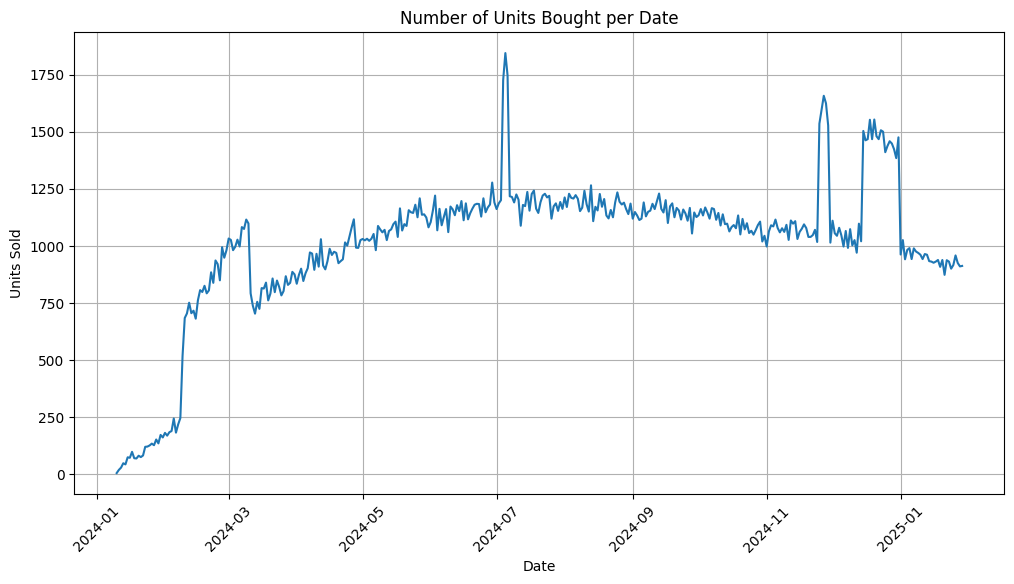

In [61]:
sales_per_day = df_sales.groupby("purchase_date").size()

# Plot the sales trend
plt.figure(figsize=(12, 6))
plt.plot(sales_per_day.index, sales_per_day.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Number of Units Bought per Date")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [126]:
len(df_sales)

115170

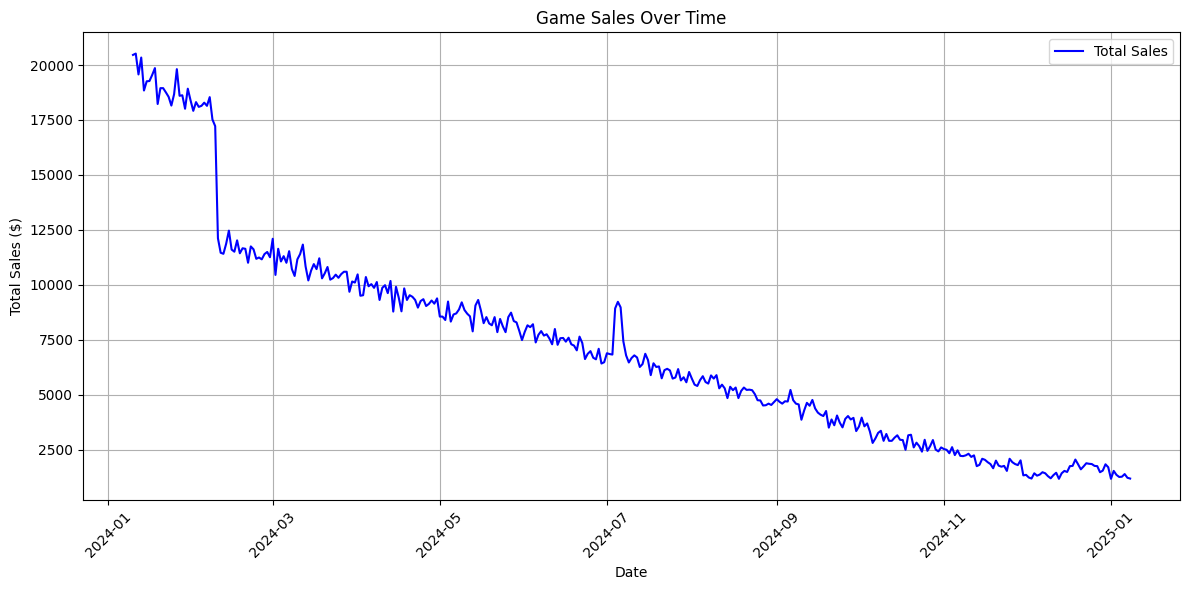

In [186]:
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'])

# Group sales by date and sum the total sales
sales_per_day = df_sales.groupby('purchase_date')['price'].sum()

# Plot the sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_per_day.index, sales_per_day.values, label='Total Sales', color='blue')
plt.title('Game Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

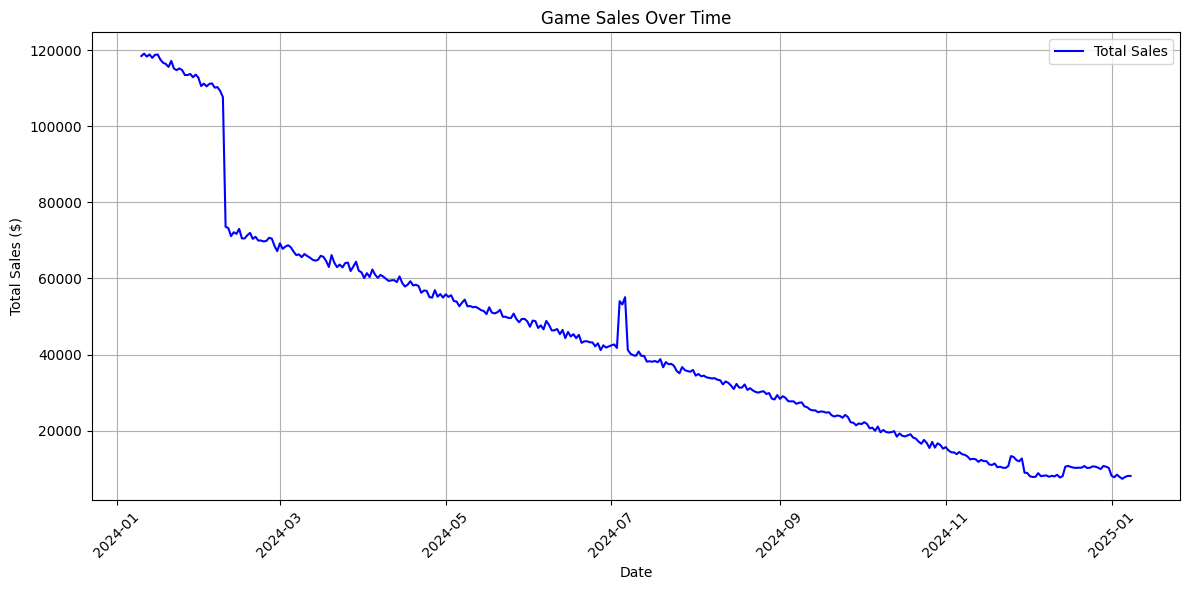

In [200]:
df_sales['purchase_date'] = pd.to_datetime(df_sales['purchase_date'])

# Group sales by date and sum the total sales
sales_per_day = df_sales.groupby('purchase_date')['price'].sum()

# Plot the sales over time
plt.figure(figsize=(12, 6))
plt.plot(sales_per_day.index, sales_per_day.values, label='Total Sales', color='blue')
plt.title('Game Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
all_sales_data[0]

{'user_id': '935ea81f-ed46-4870-a4af-ee6609361b5a',
 'game_id': '4bde6e96-2352-4c65-a61a-b5d153129f64',
 'game_name': 'Shadowstrike Royale',
 'purchase_date': Timestamp('2024-05-05 00:00:00'),
 'price': 20.0,
 'player_type': 'Strategists',
 'gamer_type': 'Day-One',
 'review_boost': 1.3,
 'rating_boost': 0.2,
 'launch_boost': 1.5,
 'holiday_boost': 1.0,
 'decline_factor': 1.0,
 'genre_match_boost': 0.5}

In [64]:
cursor

<cursor object at 0x000002375D5712A0; closed: 0>

In [88]:
def insert_order(user_id, game_id, unit_price, discount, total_price, created_at, updated_at, status = "COMPLETED", payment_method="CREDIT_CARD", quantity=1):
    cursor.execute("""
        INSERT INTO "Orders" (user_id, total_price, status, payment_method, created_at, updated_at) 
        VALUES (%s, %s, %s, %s, %s, %s) 
        RETURNING order_id;
    """, (user_id, total_price, status, payment_method, created_at, updated_at))

    order_id = cursor.fetchone()[0]  # Get the inserted order ID

    # Insert multiple items into Order_Items
    order_items = [
        (order_id, game_id, quantity, unit_price, discount),
        # Add more order items as needed
    ]

    cursor.executemany("""
        INSERT INTO "OrderItems" (order_id, game_id, quantity, unit_price, discount) 
        VALUES (%s, %s, %s, %s, %s);
    """, order_items)

    user_games = [
        (user_id, game_id, created_at, quantity),
    ]

    cursor.executemany("""
        INSERT INTO "UserGames" (user_id, game_id, purchased_at, quantity) 
        VALUES (%s, %s, %s, %s);
    """, user_games)

    conn.commit()

In [134]:
all_sales_data

[{'user_id': '935ea81f-ed46-4870-a4af-ee6609361b5a',
  'game_id': '4bde6e96-2352-4c65-a61a-b5d153129f64',
  'game_name': 'Shadowstrike Royale',
  'purchase_date': Timestamp('2024-05-05 00:00:00'),
  'price': 20.0,
  'player_type': 'Strategists',
  'gamer_type': 'Day-One',
  'review_boost': 1.3,
  'rating_boost': 0.2,
  'launch_boost': 1.5,
  'holiday_boost': 1.0,
  'decline_factor': 1.0,
  'genre_match_boost': 0.5},
 {'user_id': '7611e19b-889b-469b-ad6b-0666265b20c6',
  'game_id': '4bde6e96-2352-4c65-a61a-b5d153129f64',
  'game_name': 'Shadowstrike Royale',
  'purchase_date': Timestamp('2024-05-06 00:00:00'),
  'price': 20.0,
  'player_type': 'Explorers',
  'gamer_type': 'Day-One',
  'review_boost': 1.3,
  'rating_boost': 0.2,
  'launch_boost': 1.5,
  'holiday_boost': 1.0,
  'decline_factor': 1.0,
  'genre_match_boost': 0.9},
 {'user_id': '187095aa-404c-483a-8a7c-03a2a73fa89e',
  'game_id': '4bde6e96-2352-4c65-a61a-b5d153129f64',
  'game_name': 'Shadowstrike Royale',
  'purchase_date':

In [135]:
from tqdm import tqdm


for salesdata in tqdm(all_sales_data, desc="Inserting Sales Data", unit="order"):
    
    unit_price = salesdata['price']
    total_price = unit_price
    if salesdata['holiday_boost'] > 1.0:
        discount = 10
        total_price = round(unit_price - (discount / 100 * unit_price), 2)
    else:
        discount = 0

    insert_order(user_id=salesdata['user_id'],
                 game_id=salesdata['game_id'],
                 unit_price=unit_price,
                 discount=discount,
                 total_price=total_price,
                 created_at=salesdata['purchase_date'],
                 updated_at=salesdata['purchase_date'])



Inserting Sales Data: 100%|██████████| 115170/115170 [03:56<00:00, 487.49order/s]


In [137]:
# Close database connection
cursor.close()
conn.close()